<a href="https://colab.research.google.com/github/kassy75035/1st-PyCrawlerMarathon/blob/master/Day086_CB_ModelCheckPoint_%E4%BD%9C%E6%A5%AD_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型

參數說明：
filepath: 儲存模型的路徑與檔名
mointor: 以什麼指標作為判斷標準
save_best_only: 是否只要儲存最好的


"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
49/49 [==============================] - 12s 216ms/step - loss: 2.2364 - accuracy: 0.2670 - val_loss: 2.1626 - val_accuracy: 0.2134
Epoch 2/50
49/49 [==============================] - 8s 167ms/step - loss: 1.7494 - accuracy: 0.3937 - val_loss: 2.0052 - val_accuracy: 0.2779
Epoch 3/50
49/49 [==============================] - 9s 177ms/step - loss: 1.6215 - accuracy: 0.4326 - val_loss: 1.8543 - val_accuracy: 0.3441
Epoch 4/50
49/49 [==============================] - 9s 178ms/step - loss: 1.5474 - accuracy: 0.4569 - val_loss: 1.7463 - val_accuracy: 0.3830
Epoch 5/50
49/49 [==============================] - 8s 171ms/step - loss: 1.4909 - accuracy: 0.4796 - val_loss: 1.6537 - val_accuracy: 0.4257
Epoch 6/50
49/49 [==============================] - 8s 165ms/step - loss: 1.4449 - accuracy: 0.4966 - val_loss: 1.5936 - val_accuracy: 0.4454
Epoch 7/50
49/49 [==============================] - 8s 168ms/step - loss: 1.4056 - accuracy: 0.5102 - val_loss: 1.5585 - val_accuracy: 0.4536
Epoch

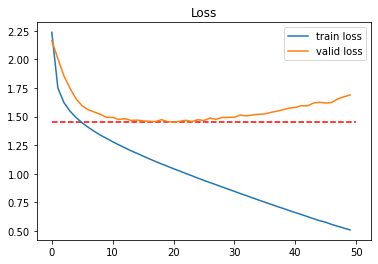

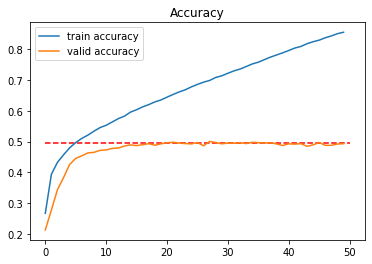

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()